In [ ]:
#imports
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.modules import flatten
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from PIL import Image
import random
import pandas as pd
from google.colab import drive
from sklearn.metrics import accuracy_score, classification_report
from copy import deepcopy
from tqdm import tqdm

In [ ]:
#mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#download and unzip data
!gdown --id 1Oql7XDlW8IOI0Rkx2q3fn2OZ5W_n4U-2 -O bloodcells_dataset_412a.zip
!unzip -q bloodcells_dataset_412a.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Oql7XDlW8IOI0Rkx2q3fn2OZ5W_n4U-2
To: /content/bloodcells_dataset_412a.zip
100% 8.50M/8.50M [00:00<00:00, 92.5MB/s]
replace bloodcells_dataset_412a/basophil/BA_577892.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace bloodcells_dataset_412a/basophil/BA_577892.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
#load and shuffle data
file_path = "./bloodcells_dataset_412a/"
baso = [f for f in listdir(file_path + "basophil") if isfile(join(file_path + "basophil", f)) and f != ".DS_Store"]
eosi = [f for f in listdir(file_path + "eosinophil") if isfile(join(file_path + "eosinophil", f)) and f != ".DS_Store"]
neutro = [f for f in listdir(file_path + "neutrophil") if isfile(join(file_path + "neutrophil", f)) and f != ".DS_Store"]
data = baso + eosi + neutro
random.shuffle(data)

In [ ]:
class BloodCell_Dataset(Dataset):
    def __init__(self, file_path, file_path_list, mode="train", validate_size=0.2, test_size=0.2):
        self.file_path = file_path
        self.classes = ["basophil", "eosinophil", "neutrophil"]
        self.class2idx = {"basophil" : 0, "eosinophil" : 1, "neutrophil" : 2}
        self.idx2class = {0 : "basophil", 1 : "eosinophil", 2 : "neutrophil"}
        self.data = file_path_list
        assert mode in ['train', 'test', 'validate'], f'mode needs to be either train or test, but it\'s {mode}'
        val_partition = int(len(self.data) * (1 - validate_size - test_size))
        test_partition = int(len(self.data) * (1 - test_size))
        if mode == 'train':
            self.data = self.data[:val_partition]
        elif mode == 'validate':
            self.data = self.data[val_partition:test_partition]
            self.tensor_imgs = []
            self.labels = []
            for i in range(len(self.data)):
                img, label = self.__getitem__(i)
                if len(img.shape) == 3:
                    img = img.unsqueeze(0)
                self.tensor_imgs.append(img)
                self.labels.append(label.item())
        elif mode == 'test':
            self.data = self.data[test_partition:]
            self.tensor_imgs = []
            self.labels = []
            for i in range(len(self.data)):
                img, label = self.__getitem__(i)
                if len(img.shape) == 3:
                    img = img.unsqueeze(0)
                self.tensor_imgs.append(img)
                self.labels.append(label.item())

            self.tensor_imgs = torch.cat(self.tensor_imgs, dim=0).type(torch.float32)
            self.labels = torch.tensor(self.labels).type(torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        file_name = self.data[i]

        if "SNE" in file_name or "NEU" in file_name or "BNE" in file_name:
            label = 2
        elif "EO" in file_name:
            label = 1
        elif "BA" in file_name:
            label = 0

        convert_tensor = transforms.ToTensor()
        path = self.file_path + self.idx2class[label] + "/" + file_name
        img = Image.open(path)
        tensor_img = convert_tensor(img)
        if tensor_img.shape != (3, 363, 360):
            tensor_img = tensor_img[:, 3:366, 3:363]
        return tensor_img.type(torch.float32), torch.tensor(label).type(torch.long)

    def get_val(self):
        return self.tensor_imgs, self.labels

    def get_test(self):
        return self.tensor_imgs, self.labels

In [ ]:
training_data = BloodCell_Dataset(file_path, data, mode='train')
validation_data = BloodCell_Dataset(file_path, data, mode='validate')
testing_data = BloodCell_Dataset(file_path, data, mode='test')

In [ ]:
class Blood_Cell_Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        #convolution
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)

        #batch normalization
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)

        #pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        #dropout
        self.dropout = nn.Dropout(0.3)

        # Fully connected layers
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, X):
        X = F.relu(self.bn1(self.conv1(X)))
        X = self.pool(X)
        X = F.relu(self.bn2(self.conv2(X)))
        X = self.pool(X)

        # Apply adaptive pooling
        X = self.global_pool(X).squeeze()

        # Fully connected layers
        X = self.dropout(F.relu(self.fc1(X)))
        logits = self.fc2(X)
        return logits

In [ ]:
def train(model, training_data, validation_data, epochs=25, batch_size=8, lr=1e-3, gamma=0.9):
    """
    Inputs:
    - model: the model to be trained (PyTorch nn.Module class object)
    - training_data: the dataset for training
    - validation_data: the dataset for validation
    - epochs: number of epochs
    - batch_size: size of the mini-batches
    - lr: learning rate
    - gamma: decay factor for the learning rate scheduler

    Outputs:
    - total_train_losses: list of training losses per epoch
    - total_val_losses: list of validation losses per epoch
    - total_train_accuracy: list of training accuracies per epoch
    - total_val_accuracy: list of validation accuracies per epoch
    """
    torch.cuda.empty_cache()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ExponentialLR(optimizer, gamma=gamma)
    loss_fn = nn.CrossEntropyLoss()

    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

    total_train_losses = []
    total_val_losses = []
    total_train_accuracy = []
    total_val_accuracy = []

    best_acc = -1
    best_model = None

    for epoch in range(epochs):
        # Training loop
        model.train()
        epoch_train_loss = 0
        num_correct_train = 0
        train_size = len(training_data)

        print(f"Epoch {epoch + 1}/{epochs}")
        with tqdm(train_dataloader, desc="Training", unit="batch") as train_progress:
            for imgs, labels in train_progress:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                logits = model(imgs)
                loss = loss_fn(logits, labels)
                loss.backward()
                optimizer.step()

                # Update metrics
                epoch_train_loss += loss.item() * imgs.size(0)  # Accumulate total loss
                preds = logits.argmax(dim=1)
                num_correct_train += (preds == labels).sum().item()

                # Update progress bar
                train_progress.set_postfix(loss=loss.item())

        avg_train_loss = epoch_train_loss / train_size
        train_accuracy = num_correct_train / train_size
        total_train_losses.append(avg_train_loss)
        total_train_accuracy.append(train_accuracy)

        # Validation loop
        model.eval()
        epoch_val_loss = 0
        num_correct_val = 0
        val_size = len(validation_data)

        with torch.no_grad():
            with tqdm(val_dataloader, desc="Validation", unit="batch") as val_progress:
                for imgs, labels in val_progress:
                    imgs, labels = imgs.to(device), labels.to(device)
                    logits = model(imgs)
                    loss = loss_fn(logits, labels)

                    # Update metrics
                    epoch_val_loss += loss.item() * imgs.size(0)  # Accumulate total loss
                    preds = logits.argmax(dim=1)
                    num_correct_val += (preds == labels).sum().item()

                    # Update progress bar
                    val_progress.set_postfix(loss=loss.item())

        avg_val_loss = epoch_val_loss / val_size
        val_accuracy = num_correct_val / val_size
        total_val_losses.append(avg_val_loss)
        total_val_accuracy.append(val_accuracy)

        # Save best model
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_model = deepcopy(model)

        # Print epoch summary
        print(f"Train Loss: {avg_train_loss:.4f}\tTrain Acc: {train_accuracy:.4f}\tVal Loss: {avg_val_loss:.4f}\tVal Acc: {val_accuracy:.4f}")

        # Update scheduler
        scheduler.step()

    print(f"Resetting model to the best state... Best Validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model.state_dict())

    # Graph training and validation losses
    losses = {"Training Loss": total_train_losses, "Validation Loss": total_val_losses}
    df = pd.DataFrame(losses, index=range(epochs))
    ax = df.plot.line()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Losses")

    accuracies = {"Training Accuracy": total_train_accuracy, "Validation Accuracy": total_val_accuracy}
    df = pd.DataFrame(accuracies, index=range(epochs))
    ax = df.plot.line()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy")

    return total_train_losses, total_val_losses, total_train_accuracy, total_val_accuracy

Epoch 1/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.26batch/s, loss=1.12]


Train Loss: 1.0887	Train Acc: 0.4110	Val Loss: 1.1494	Val Acc: 0.3980
Epoch 2/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.52batch/s, loss=1.14]


Train Loss: 1.0271	Train Acc: 0.4315	Val Loss: 1.0664	Val Acc: 0.4592
Epoch 3/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.97batch/s, loss=1.15]


Train Loss: 0.9818	Train Acc: 0.4897	Val Loss: 1.0728	Val Acc: 0.2449
Epoch 4/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.66batch/s, loss=3.07]


Train Loss: 0.9148	Train Acc: 0.5925	Val Loss: 2.6057	Val Acc: 0.2347
Epoch 5/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.62batch/s, loss=10.6]


Train Loss: 0.8345	Train Acc: 0.6336	Val Loss: 11.0481	Val Acc: 0.3673
Epoch 6/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.39batch/s, loss=5.44]


Train Loss: 0.6887	Train Acc: 0.7568	Val Loss: 5.8246	Val Acc: 0.3673
Epoch 7/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.71batch/s, loss=5.35]


Train Loss: 0.6152	Train Acc: 0.7774	Val Loss: 4.5574	Val Acc: 0.2857
Epoch 8/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.33batch/s, loss=2.34]


Train Loss: 0.6011	Train Acc: 0.7637	Val Loss: 2.9381	Val Acc: 0.4490
Epoch 9/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.89batch/s, loss=2.78]


Train Loss: 0.4996	Train Acc: 0.8151	Val Loss: 1.9211	Val Acc: 0.3571
Epoch 10/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.80batch/s, loss=0.293]


Train Loss: 0.4079	Train Acc: 0.8699	Val Loss: 0.3558	Val Acc: 0.8980
Epoch 11/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.88batch/s, loss=0.358]


Train Loss: 0.4139	Train Acc: 0.8801	Val Loss: 0.3857	Val Acc: 0.9286
Epoch 12/40


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.47batch/s, loss=0.791]


Train Loss: 0.3242	Train Acc: 0.9007	Val Loss: 0.5612	Val Acc: 0.7245
Epoch 13/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.44batch/s, loss=0.182]


Train Loss: 0.3216	Train Acc: 0.8973	Val Loss: 0.2719	Val Acc: 0.9286
Epoch 14/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.13batch/s, loss=1.92]


Train Loss: 0.2957	Train Acc: 0.9041	Val Loss: 1.3382	Val Acc: 0.3980
Epoch 15/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.99batch/s, loss=0.271]


Train Loss: 0.2738	Train Acc: 0.9384	Val Loss: 0.2553	Val Acc: 0.9082
Epoch 16/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.14batch/s, loss=0.307]


Train Loss: 0.2750	Train Acc: 0.9075	Val Loss: 0.2680	Val Acc: 0.9184
Epoch 17/40


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.47batch/s, loss=0.081]


Train Loss: 0.2920	Train Acc: 0.9144	Val Loss: 0.3105	Val Acc: 0.8673
Epoch 18/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.95batch/s, loss=0.489]


Train Loss: 0.2525	Train Acc: 0.9349	Val Loss: 0.4459	Val Acc: 0.8265
Epoch 19/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.00batch/s, loss=0.121]


Train Loss: 0.2137	Train Acc: 0.9384	Val Loss: 0.2254	Val Acc: 0.9184
Epoch 20/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.75batch/s, loss=0.179]


Train Loss: 0.1924	Train Acc: 0.9521	Val Loss: 0.2011	Val Acc: 0.9490
Epoch 21/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.88batch/s, loss=0.122]


Train Loss: 0.1885	Train Acc: 0.9418	Val Loss: 0.1992	Val Acc: 0.9388
Epoch 22/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.59batch/s, loss=0.196]


Train Loss: 0.2222	Train Acc: 0.9247	Val Loss: 0.2067	Val Acc: 0.9286
Epoch 23/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.99batch/s, loss=0.0317]


Train Loss: 0.2158	Train Acc: 0.9349	Val Loss: 0.2835	Val Acc: 0.8878
Epoch 24/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.78batch/s, loss=0.17]


Train Loss: 0.1956	Train Acc: 0.9589	Val Loss: 0.2053	Val Acc: 0.9592
Epoch 25/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.83batch/s, loss=0.0801]


Train Loss: 0.1894	Train Acc: 0.9589	Val Loss: 0.1893	Val Acc: 0.9592
Epoch 26/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.95batch/s, loss=0.126]


Train Loss: 0.1820	Train Acc: 0.9486	Val Loss: 0.1781	Val Acc: 0.9592
Epoch 27/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.12batch/s, loss=0.124]


Train Loss: 0.1733	Train Acc: 0.9589	Val Loss: 0.1703	Val Acc: 0.9592
Epoch 28/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.76batch/s, loss=0.0571]


Train Loss: 0.2158	Train Acc: 0.9075	Val Loss: 0.1807	Val Acc: 0.9286
Epoch 29/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.01batch/s, loss=0.204]


Train Loss: 0.1777	Train Acc: 0.9452	Val Loss: 0.1820	Val Acc: 0.9490
Epoch 30/40


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.03batch/s, loss=0.263]


Train Loss: 0.1959	Train Acc: 0.9589	Val Loss: 0.2026	Val Acc: 0.9490
Epoch 31/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.33batch/s, loss=0.0683]


Train Loss: 0.1680	Train Acc: 0.9692	Val Loss: 0.1585	Val Acc: 0.9694
Epoch 32/40


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.08batch/s, loss=0.105]


Train Loss: 0.1932	Train Acc: 0.9384	Val Loss: 0.1536	Val Acc: 0.9592
Epoch 33/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.22batch/s, loss=0.0865]


Train Loss: 0.1607	Train Acc: 0.9658	Val Loss: 0.1698	Val Acc: 0.9796
Epoch 34/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.98batch/s, loss=0.0945]


Train Loss: 0.1904	Train Acc: 0.9349	Val Loss: 0.1577	Val Acc: 0.9796
Epoch 35/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.93batch/s, loss=0.0924]


Train Loss: 0.1973	Train Acc: 0.9555	Val Loss: 0.1608	Val Acc: 0.9694
Epoch 36/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.20batch/s, loss=0.075]


Train Loss: 0.1611	Train Acc: 0.9486	Val Loss: 0.1503	Val Acc: 0.9694
Epoch 37/40


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.05batch/s, loss=0.0613]


Train Loss: 0.1953	Train Acc: 0.9384	Val Loss: 0.1625	Val Acc: 0.9592
Epoch 38/40


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.44batch/s, loss=0.0965]


Train Loss: 0.1592	Train Acc: 0.9589	Val Loss: 0.1553	Val Acc: 0.9694
Epoch 39/40


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.04batch/s, loss=0.069]


Train Loss: 0.1629	Train Acc: 0.9555	Val Loss: 0.1520	Val Acc: 0.9694
Epoch 40/40


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.07batch/s, loss=0.0695]


Train Loss: 0.1887	Train Acc: 0.9452	Val Loss: 0.1474	Val Acc: 0.9694
Resetting model to the best state... Best Validation Accuracy: 0.9796


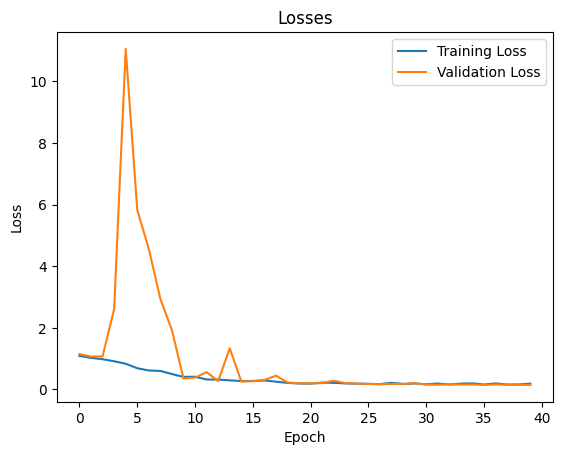

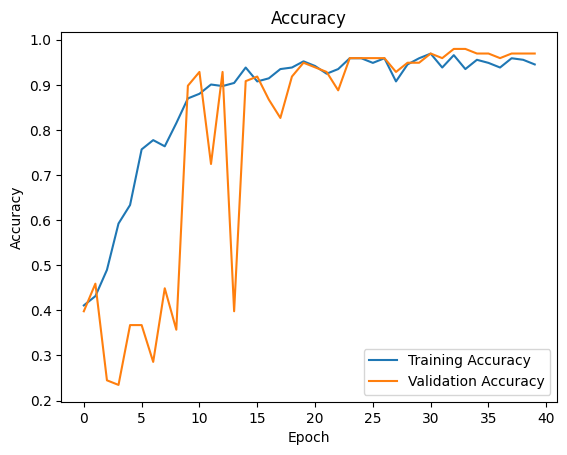

In [ ]:
model = Blood_Cell_Classifier()
total_train_losses, total_val_losses, total_train_accuracy, total_val_accuracy = train(
    model, training_data, validation_data, epochs=40, batch_size=16, lr=1e-2, gamma=0.9)

In [ ]:
def evaluate_test_data(model, test_dataset, batch_size=16):
    """
    Evaluate the test dataset using the trained model.

    Args:
        model: Trained Blood_Cell_Classifier model.
        test_dataset: BloodCell_Dataset in 'test' mode.
        batch_size: Batch size for the test DataLoader.

    Returns:
        None. Prints the test loss, accuracy, and classification report.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Get test data
    test_dataloader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    test_imgs, test_labels = test_dataset.get_test()
    test_labels = test_labels.to(device)

    # Initialize loss and predictions
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0.0
    all_predictions = []
    ground_truths = []

    with torch.no_grad():
        for imgs, labels in test_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)

            # Forward pass
            logits = model(imgs)
            loss = loss_fn(logits, labels)
            total_loss += loss.item() * imgs.size(0)  # Accumulate loss

            # Predictions
            predictions = logits.argmax(dim=1)
            all_predictions.extend(predictions.cpu().tolist())
            ground_truths.extend(labels.cpu().tolist())

    # Calculate overall metrics
    avg_loss = total_loss / len(test_dataset)
    accuracy = accuracy_score(ground_truths, all_predictions)

    # Print results
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(
        ground_truths,
        all_predictions,
        target_names=test_dataset.classes
    ))


In [ ]:
evaluate_test_data(model, testing_data)

Test Loss: 0.1637
Test Accuracy: 0.9592

Classification Report:
              precision    recall  f1-score   support

    basophil       0.95      0.90      0.92        20
  eosinophil       1.00      0.97      0.98        31
  neutrophil       0.94      0.98      0.96        47

    accuracy                           0.96        98
   macro avg       0.96      0.95      0.96        98
weighted avg       0.96      0.96      0.96        98



In [ ]:
torch.save(model, "model1.pt")